In [1]:
import numpy as np
from bench import (
    change_model as ch, 
    summary_measures as sm, 
    continuous_change_glm
)
import matplotlib.pyplot as plt

## Acquisition parameters

In [2]:
# Load acquisition parameters

acq_npz = "data/acquisition_params_for_exvivo_data.npz"
acq_data = np.load(acq_npz)
bvalues = acq_data["a"]
bvecs = acq_data["b"]

## Change model

In [3]:
# Load change model

ch_mdl = ch.ChangeModel.load("data/change_model_for_exvivo_data")
sm_names = ch_mdl.summary_names
free_params = ch_mdl.model_names
free_params[0] = "None"

/Users/dkor/opt/miniconda3/envs/cbench_env/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator PolynomialFeatures from version 1.2.1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


## Load data

In [4]:
# Load diffusion-weighted imaging data
dwi = np.load("data/dwi_for_exvivo_data.npz")["a"]
sms = sm.fit_shm(dwi, shm_degree=2, bval=bvalues, bvec=bvecs)

# Load microscopy-derived metrics
microscopy_data = np.load("data/microscopy_for_exvivo_data.npz")
nissl = microscopy_data["a"]
myelin = microscopy_data["b"]
m_odi = microscopy_data["c"]
n_odi = microscopy_data["d"]

## Dictionary of microscopy metrics

In [5]:
# Create dictionary of microscopy metrics
dictionary_of_axes = {
    "nissl": nissl,
    "myelin": myelin,
    "myelin_odi": m_odi,
    "nissl_odi": n_odi,
}

# Calculate effect sizes
effect_size_dict = {
    "baseline": 1,
    "nissl": np.percentile(nissl, 99.9) - np.percentile(nissl, 0.1),
    "myelin": np.percentile(myelin, 99.9) - np.percentile(myelin, 0.1),
    "myelin_odi": np.percentile(m_odi, 99.9) - np.percentile(m_odi, 0.1),
    "nissl_odi": np.percentile(n_odi, 99.9) - np.percentile(n_odi, 0.1),
}

# Print effect sizes
for key, value in effect_size_dict.items():
    if key != "baseline":
        print(f"effect_size ({key}): {value}")

effect_size (nissl): 0.43252774859094145
effect_size (myelin): 0.9938887827115283
effect_size (myelin_odi): 0.9378317109197399
effect_size (nissl_odi): 0.942522719286383


## Inferences using multiple regressors 

In [6]:
# Bootstrap method
dictionary_of_betas, dictionary_of_noise_covar = continuous_change_glm.estimate_continuous_noise_covariance_and_betas(
    signals=dwi,
    dictionary_of_axes=dictionary_of_axes,
    bvalues=bvalues,
    bvecs=bvecs,
    sm_names=sm_names,
    samples=2000,
    iterations=1000,
    shm_degree=2,
    effect_size_dict=effect_size_dict,
    neglect_b0=True,
)

running inference for 1 samples ...
number of samples with nan posterior: 0


/Users/dkor/OneDrive - Nexus365/benchs/to_be_uploaded/continuous_bench/bench/continuous_change_glm.py:635: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


running inference for 1 samples ...
number of samples with nan posterior: 0
running inference for 1 samples ...


/Users/dkor/OneDrive - Nexus365/benchs/to_be_uploaded/continuous_bench/bench/continuous_change_glm.py:635: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


number of samples with nan posterior: 0
running inference for 1 samples ...


/Users/dkor/OneDrive - Nexus365/benchs/to_be_uploaded/continuous_bench/bench/continuous_change_glm.py:635: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/Users/dkor/OneDrive - Nexus365/benchs/to_be_uploaded/continuous_bench/bench/change_model.py:310: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  neg_int = scipy.integrate.quad(post_pdf, lower, upper, points=[neg_peak], epsrel=1e-3)[0]


number of samples with nan posterior: 0


/Users/dkor/OneDrive - Nexus365/benchs/to_be_uploaded/continuous_bench/bench/continuous_change_glm.py:635: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


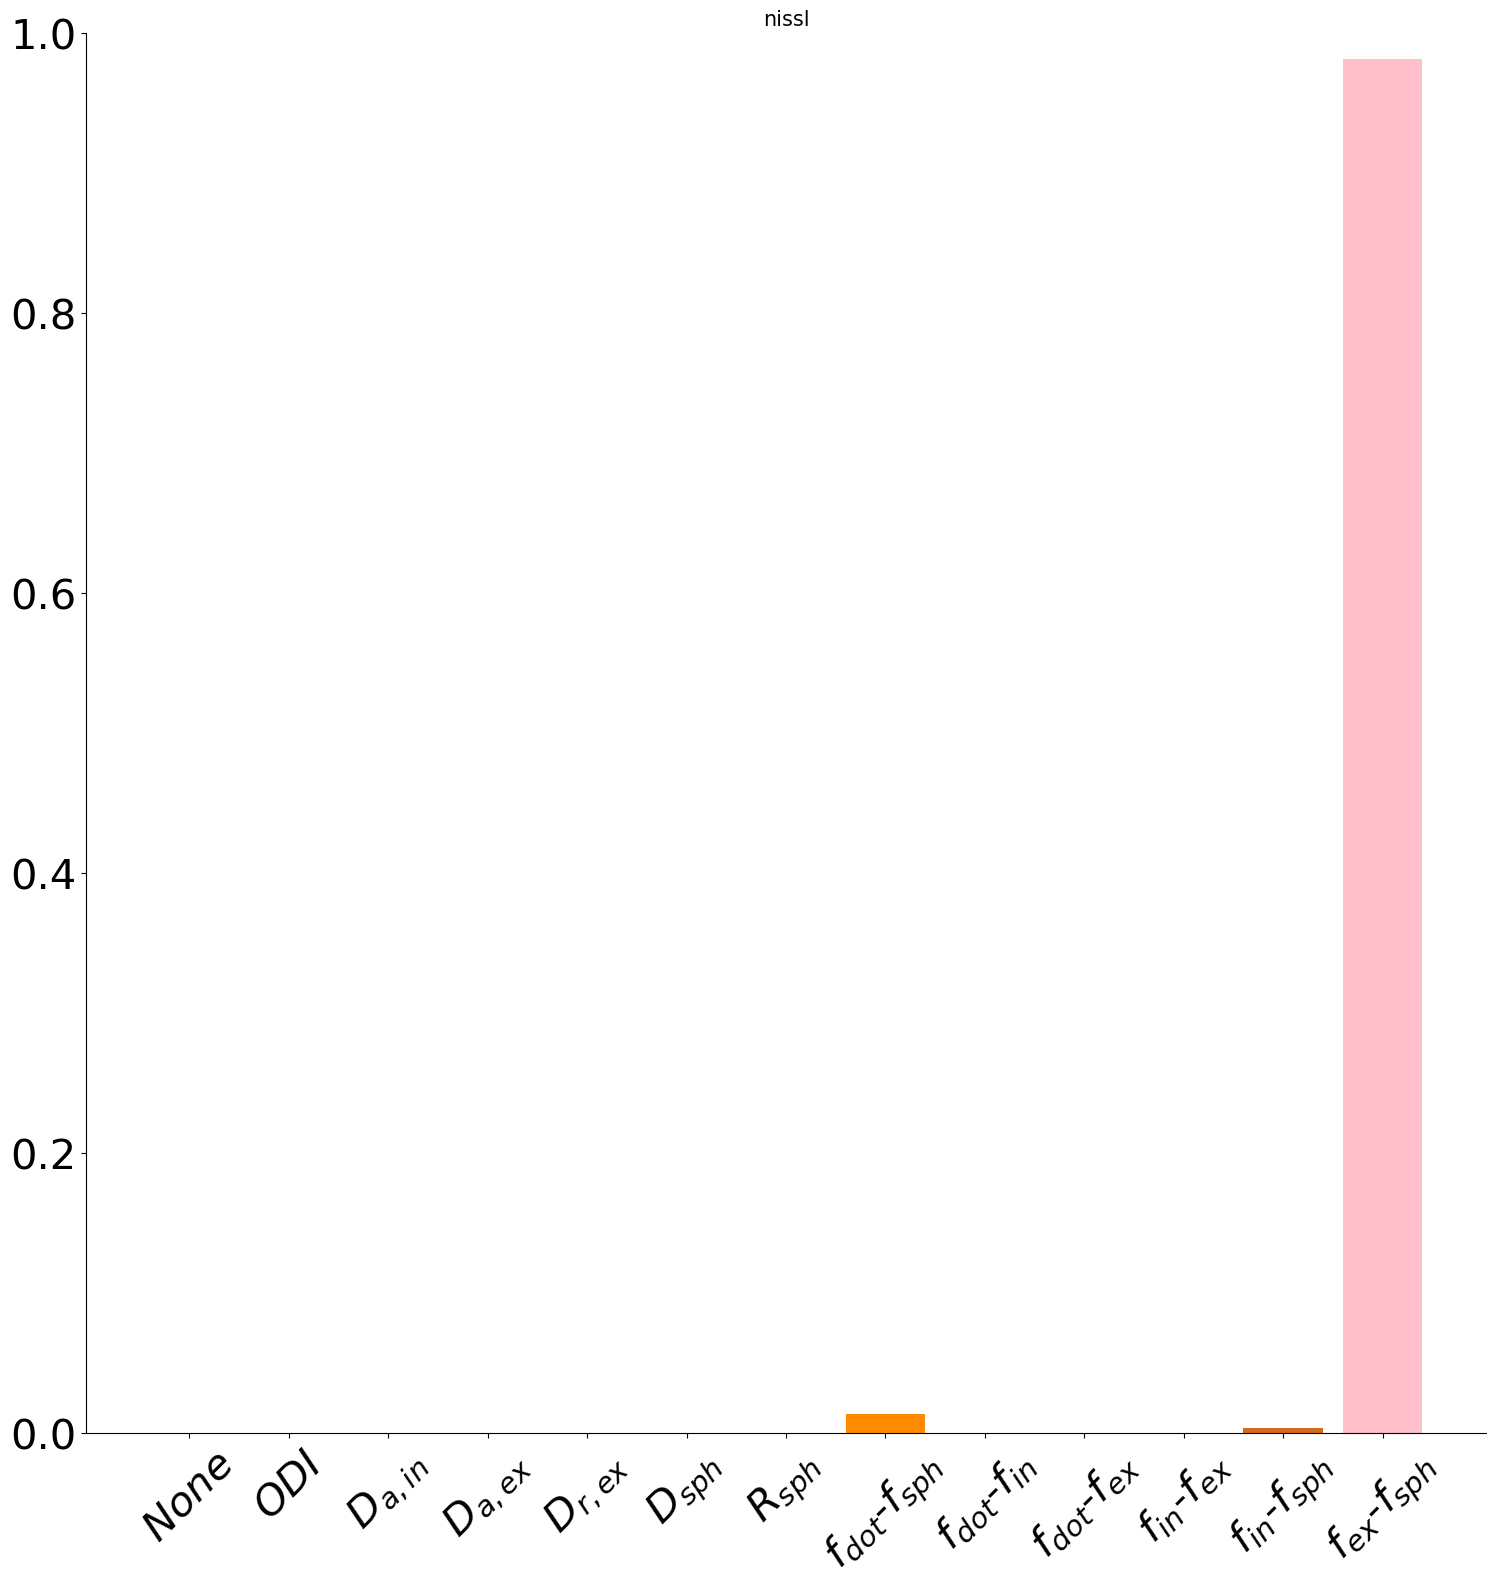

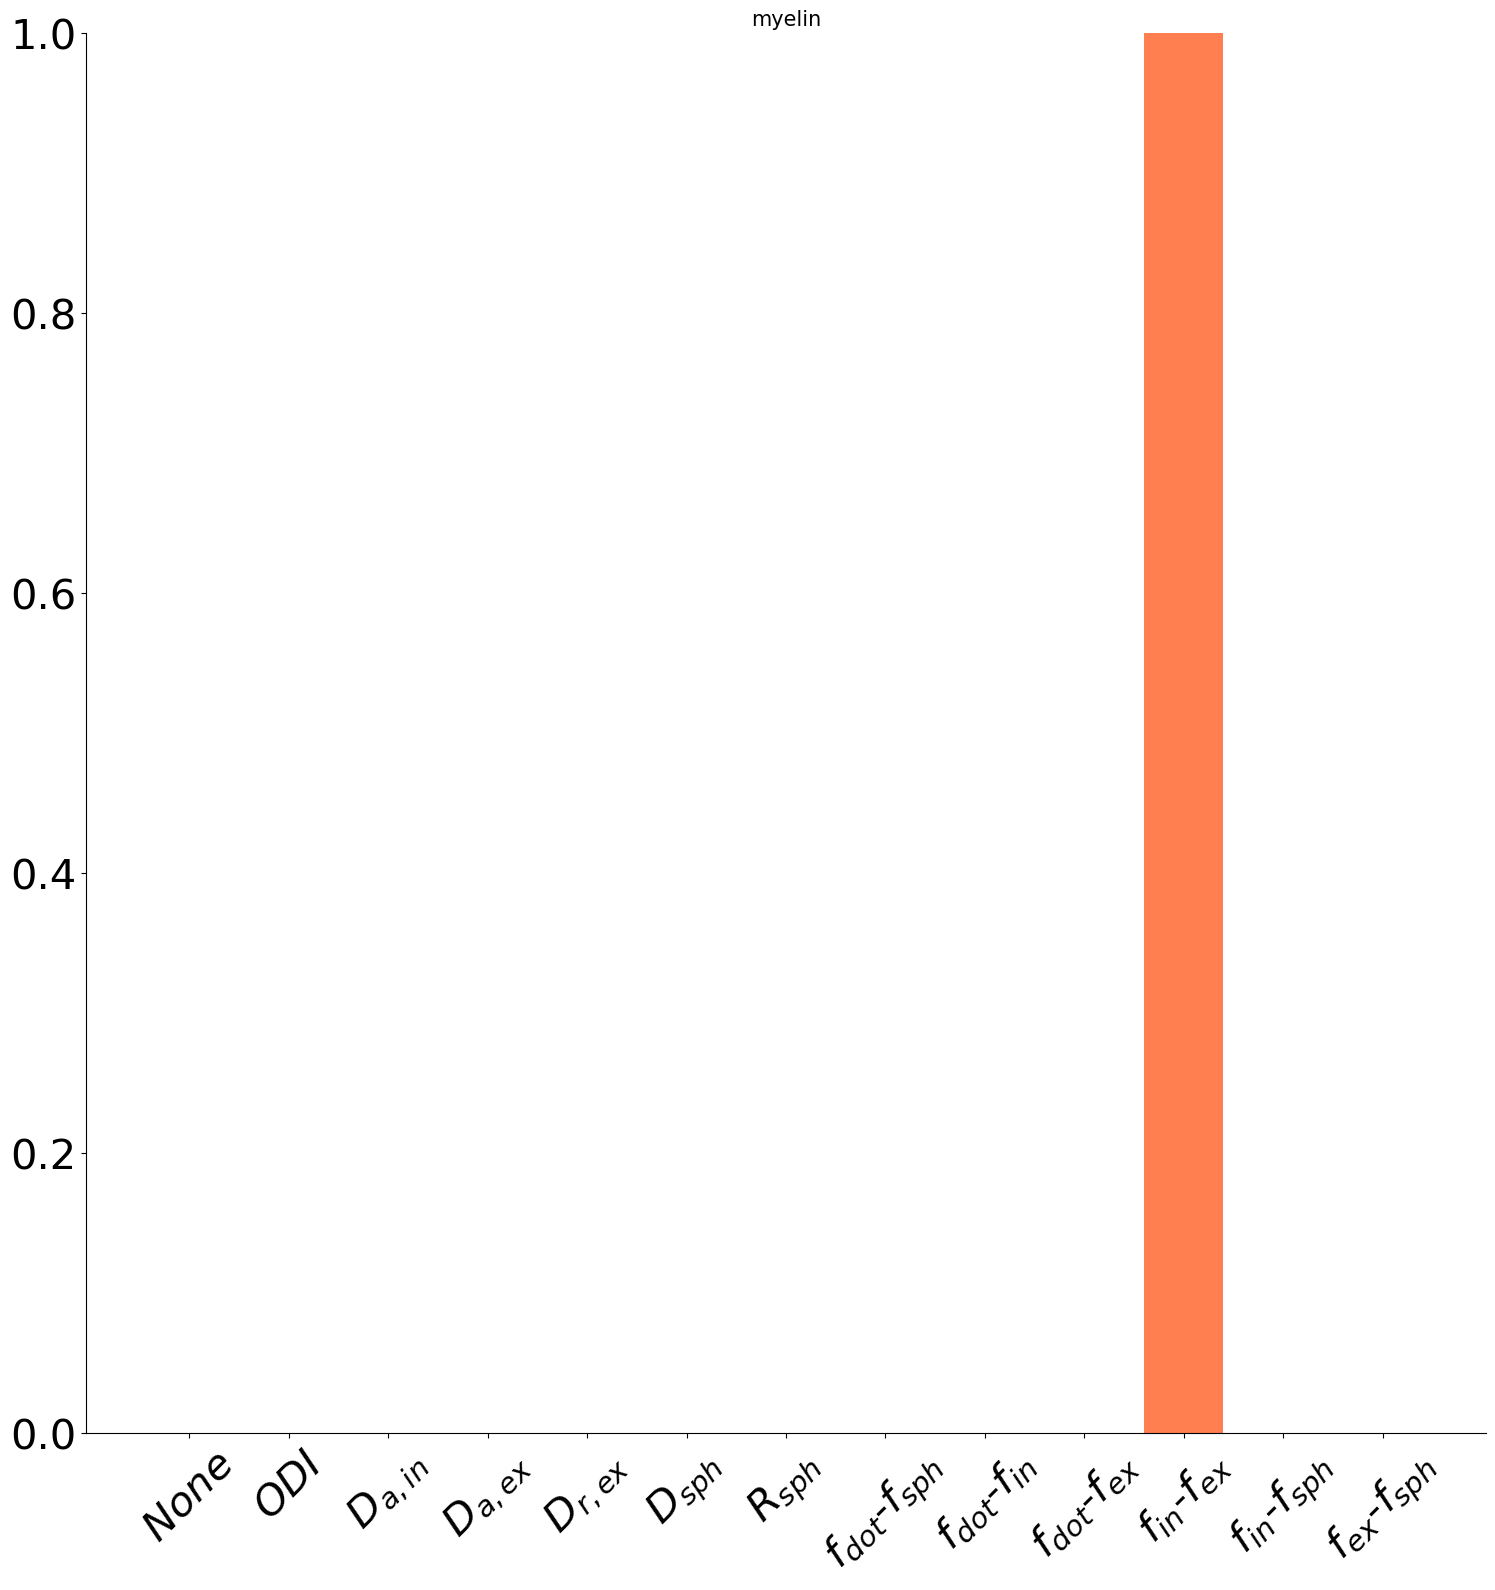

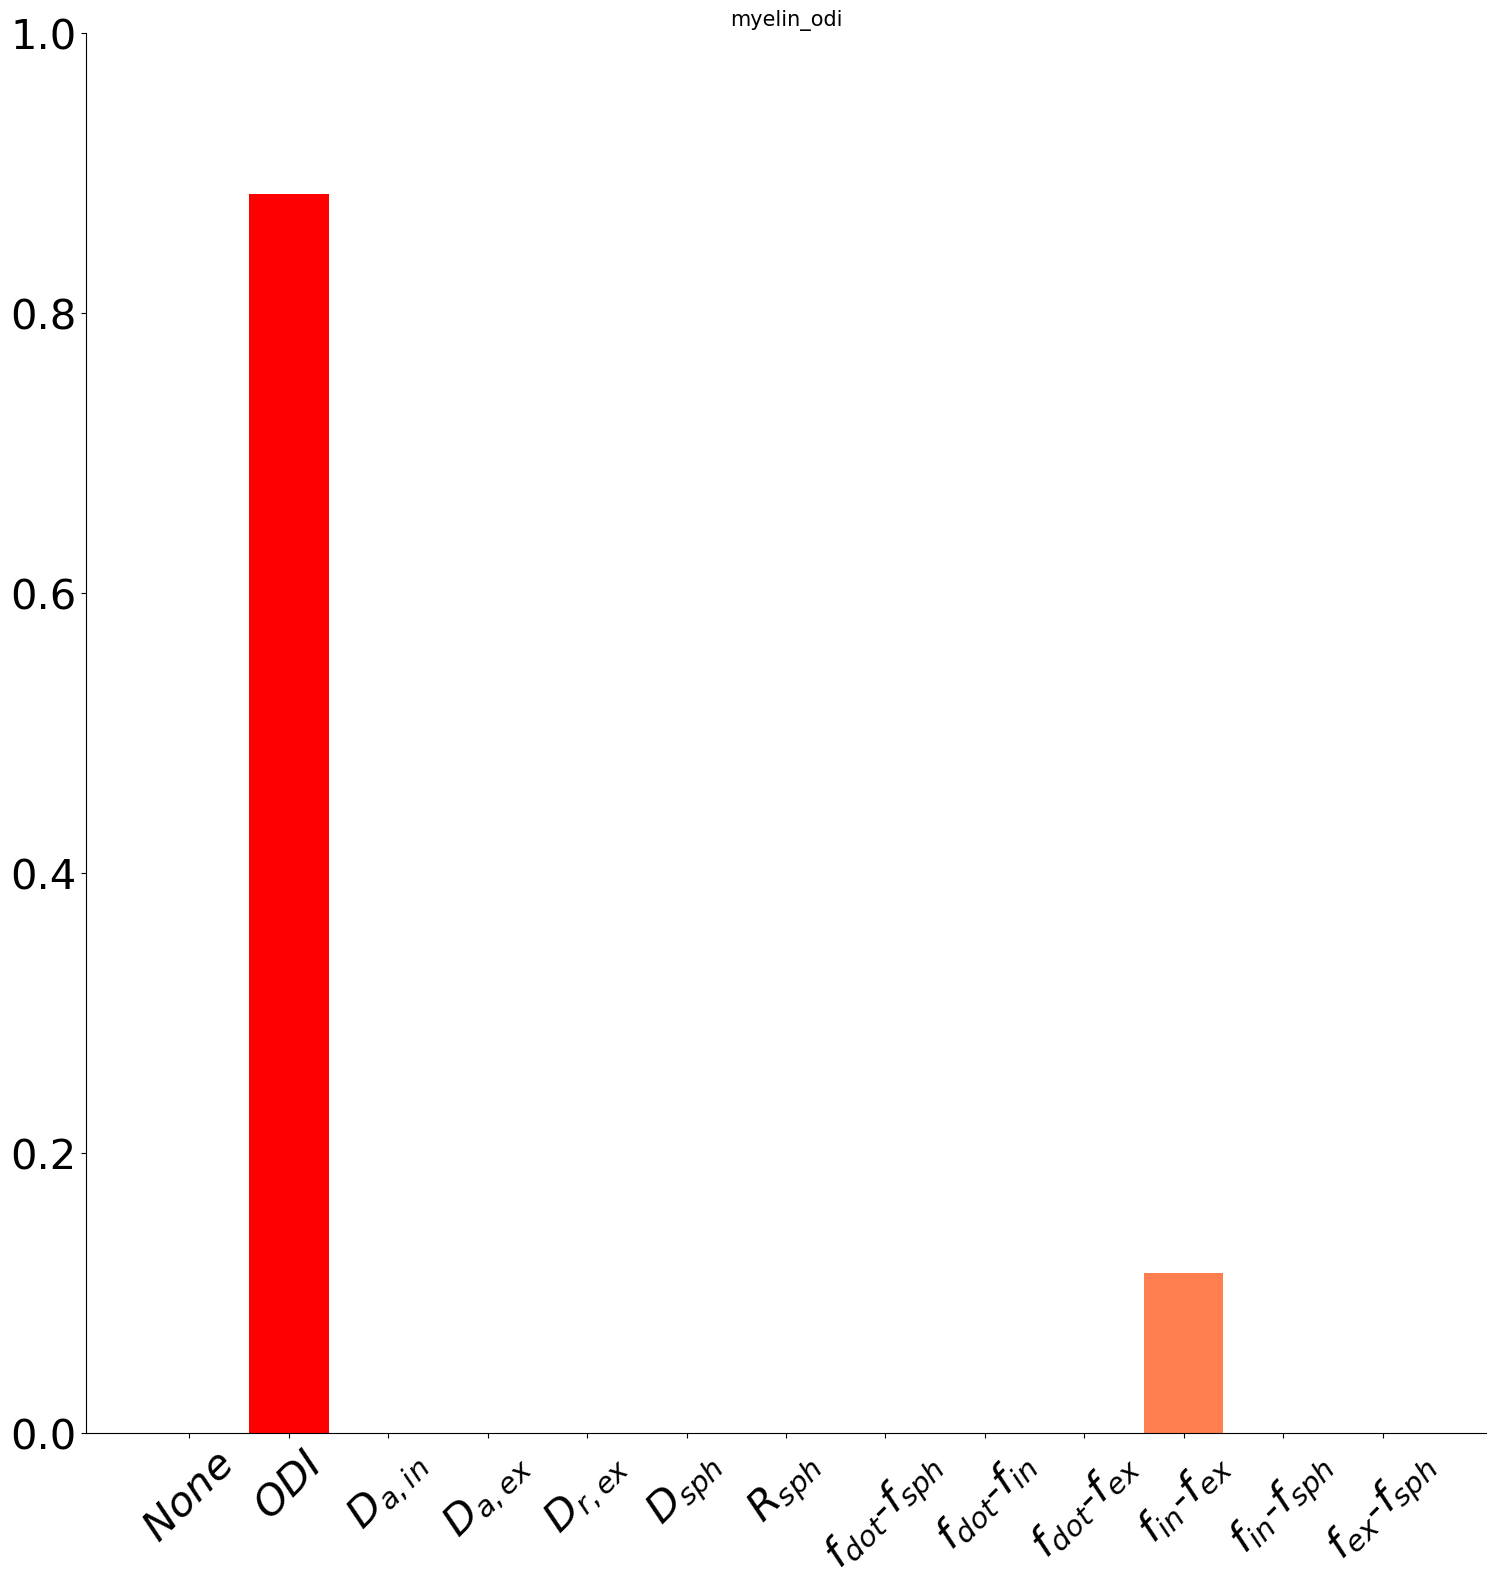

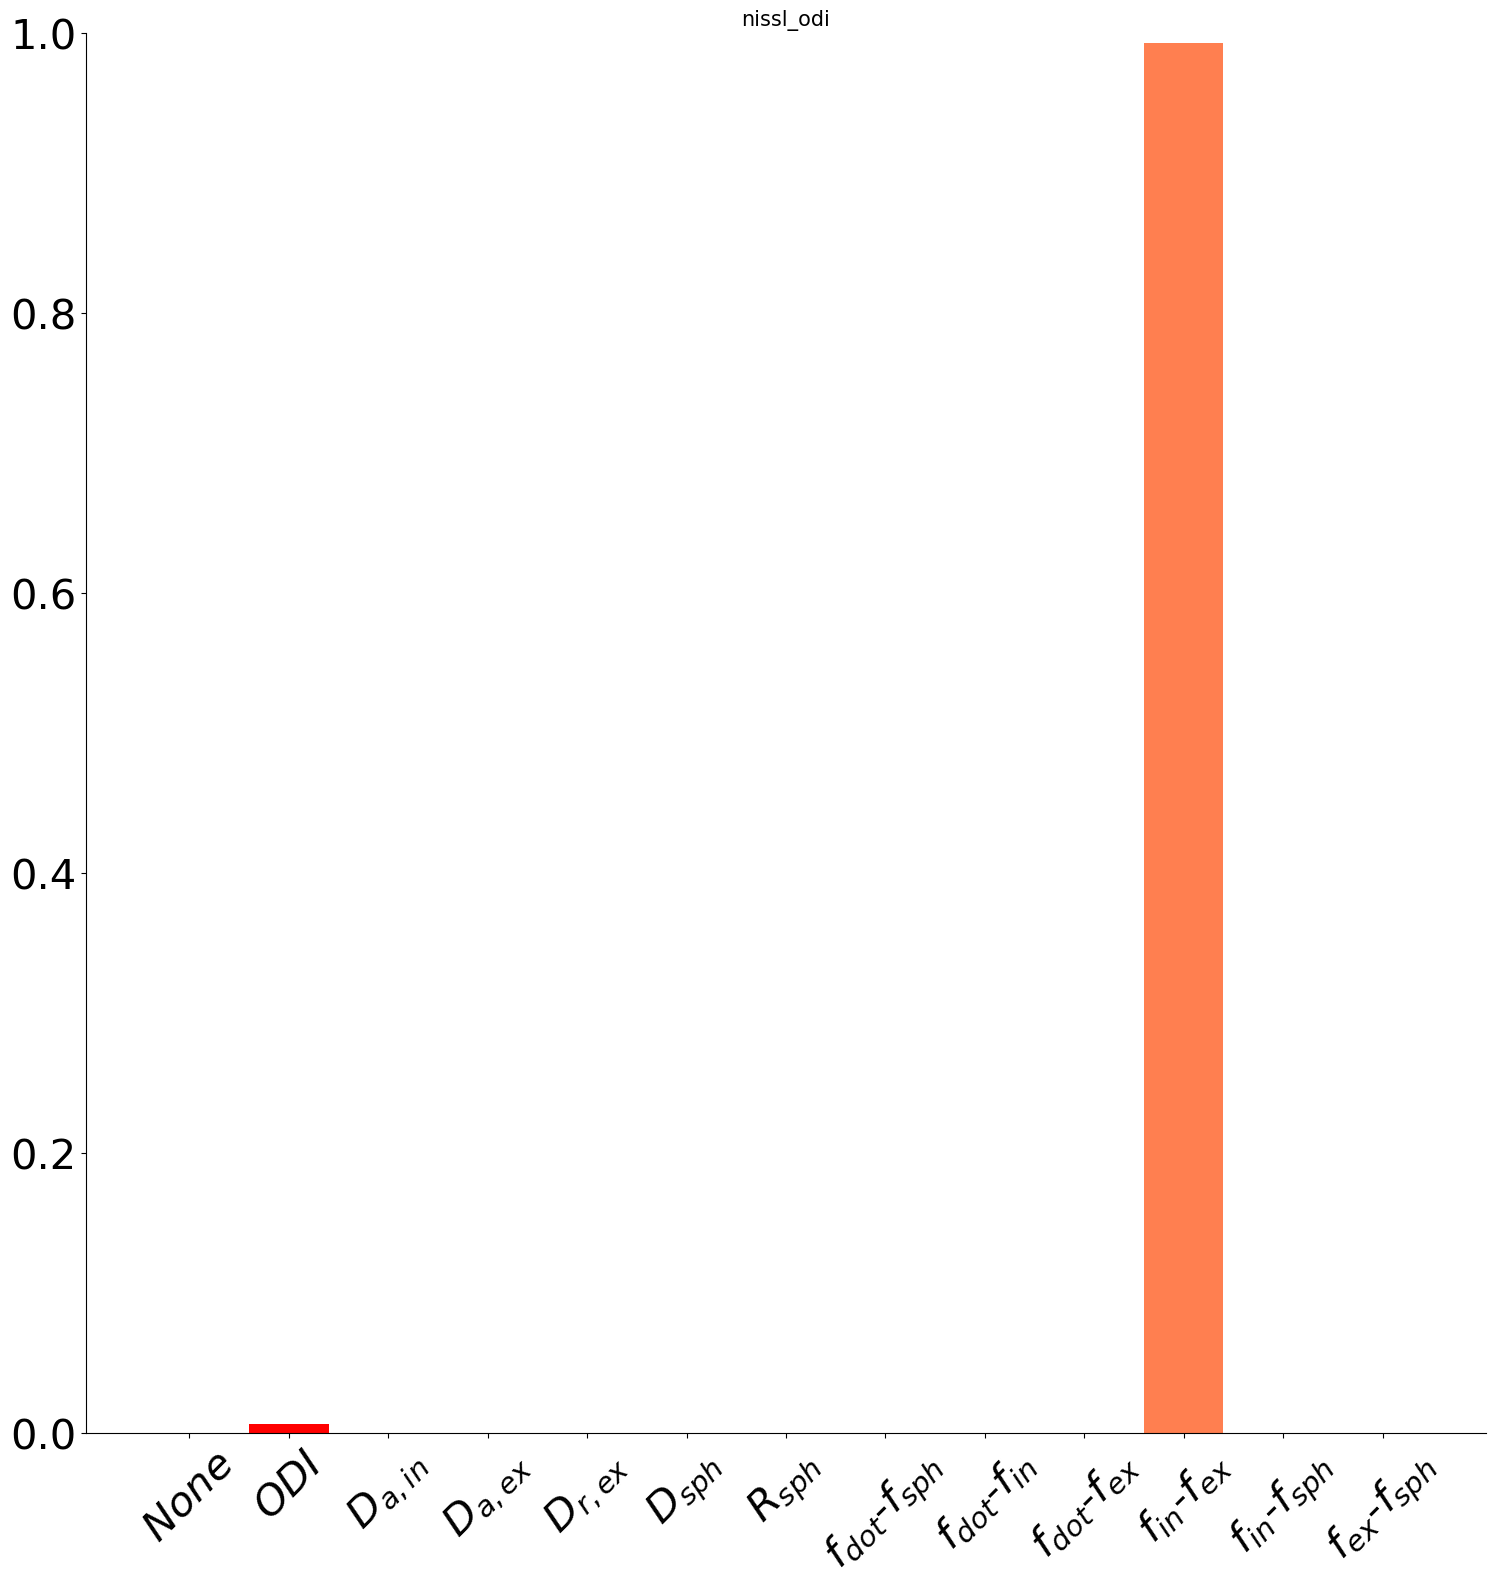

In [7]:
axes_of_change = list(dictionary_of_axes.keys())

# Baseline for bootstrapping
baseline = dictionary_of_betas["baseline"].mean(axis=0)

# Regularisation to avoid overfitting and singularity in the noise covariance matrix
std = 1e-5
reg = (std**2) / baseline.shape[0]

# Inference and plotting
amount_dict = {}
all_parameters_amount_dict = {}
inf_change_dict = {}

for axe in axes_of_change:
    # Bootstrapping
    noise_cov = dictionary_of_noise_covar[axe] + np.eye(4) * reg
    beta = dictionary_of_betas[axe].mean(axis=0)[np.newaxis, :]
    
    prob, inf_change, amount, _ = ch_mdl.infer(
        baseline[np.newaxis, :], beta, noise_cov, parallel=False
    )
    
    amount_dict[axe] = amount[0, inf_change]
    all_parameters_amount_dict[axe] = amount
    inf_change_dict[axe] = inf_change
    
    # Plot probabilities
    continuous_change_glm.plot_probs(
        probs=prob, 
        free_params=free_params, 
        title=axe, 
        ymax=1, 
        xticksize=30, 
        figsize=(14, 14)
    )
    plt.xticks(rotation=45)
    plt.yticks(size=30)